In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.impute import KNNImputer

#model selection from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
#ensemble
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier,AdaBoostClassifier,GradientBoostingClassifier
#metrics
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
#pca
from sklearn.decomposition import PCA
#data_balance
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
#warnings
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
df = pd.read_csv('train.csv')

df=df.drop(['UniqueID', 'branch_id','supplier_id', 'Current_pincode_ID','State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag'],axis=1)

In [ ]:
df.shape

In [ ]:
df.columns

In [27]:
list(df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts().index)

['No Bureau History Available',
 'C-Very Low Risk',
 'A-Very Low Risk',
 'D-Very Low Risk',
 'B-Very Low Risk',
 'M-Very High Risk',
 'F-Low Risk',
 'K-High Risk',
 'H-Medium Risk',
 'E-Low Risk',
 'I-Medium Risk',
 'G-Low Risk',
 'Not Scored: Sufficient History Not Available',
 'J-High Risk',
 'Not Scored: Not Enough Info available on the customer',
 'Not Scored: No Activity seen on the customer (Inactive)',
 'Not Scored: No Updates available in last 36 months',
 'L-Very High Risk',
 'Not Scored: Only a Guarantor',
 'Not Scored: More than 50 active Accounts found']

In [28]:
df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts()

No Bureau History Available                                116950
C-Very Low Risk                                             16045
A-Very Low Risk                                             14124
D-Very Low Risk                                             11358
B-Very Low Risk                                              9201
M-Very High Risk                                             8776
F-Low Risk                                                   8485
K-High Risk                                                  8277
H-Medium Risk                                                6855
E-Low Risk                                                   5821
I-Medium Risk                                                5557
G-Low Risk                                                   3988
Not Scored: Sufficient History Not Available                 3765
J-High Risk                                                  3748
Not Scored: Not Enough Info available on the customer        3672
Not Scored

No Bureau History Available


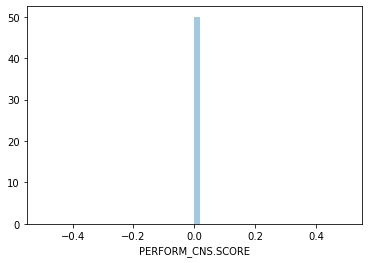

C-Very Low Risk


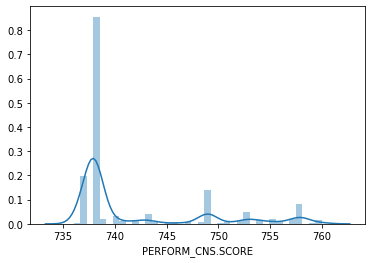

A-Very Low Risk


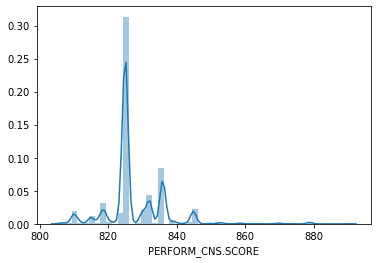

D-Very Low Risk


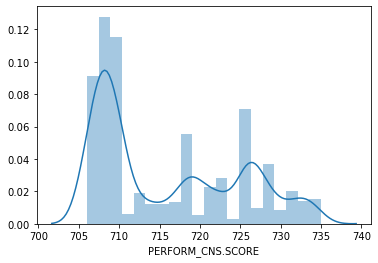

B-Very Low Risk


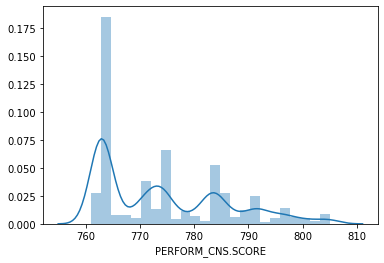

M-Very High Risk


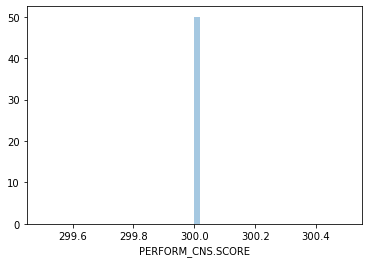

F-Low Risk


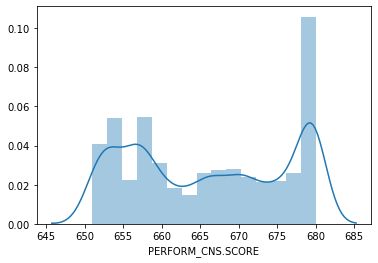

K-High Risk


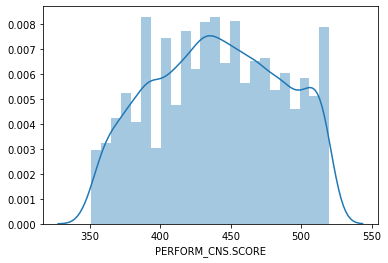

H-Medium Risk


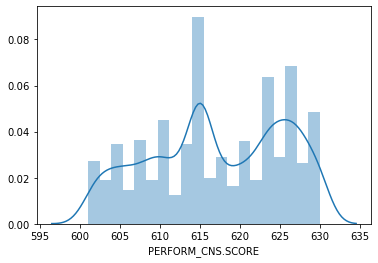

E-Low Risk


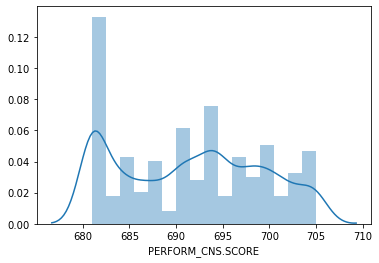

I-Medium Risk


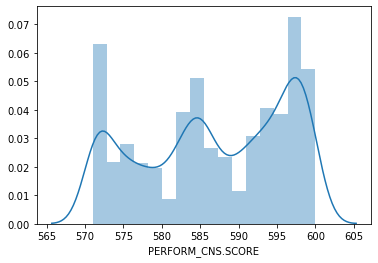

G-Low Risk


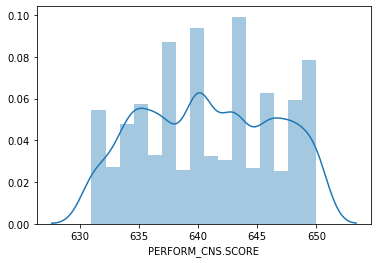

Not Scored: Sufficient History Not Available


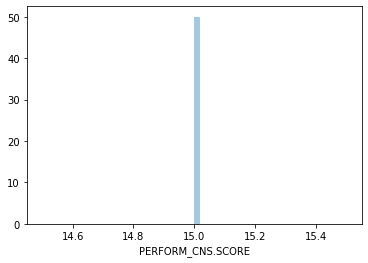

J-High Risk


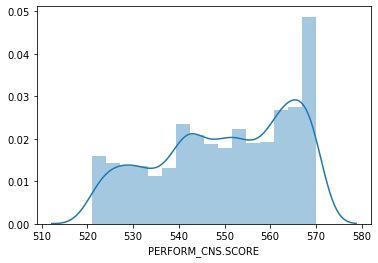

Not Scored: Not Enough Info available on the customer


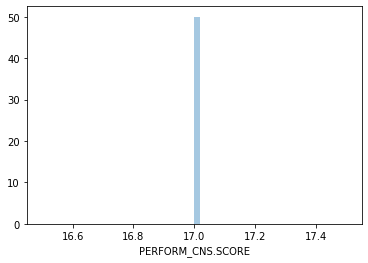

Not Scored: No Activity seen on the customer (Inactive)


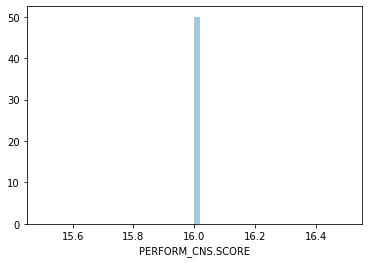

Not Scored: No Updates available in last 36 months


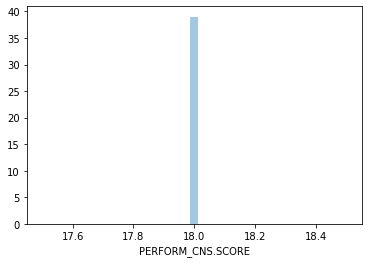

L-Very High Risk


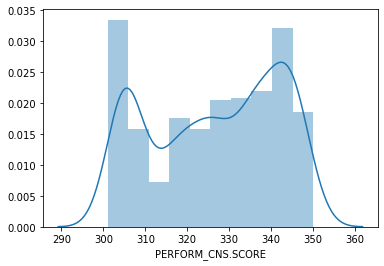

Not Scored: Only a Guarantor


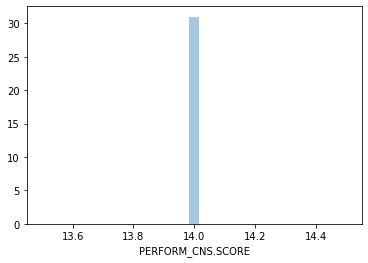

Not Scored: More than 50 active Accounts found


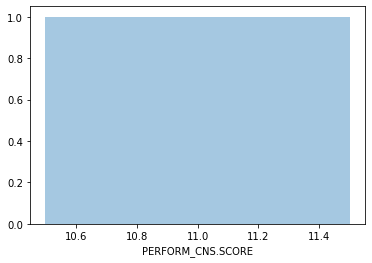

In [29]:
for i in list(df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts().index):
    df1=df.groupby('PERFORM_CNS.SCORE.DESCRIPTION').get_group(i)
    print(i)
    sns.distplot(df1['PERFORM_CNS.SCORE'])
    plt.show()

In [3]:
def credit_risk(df):
    d1=[]
    d2=[]
    for i in df:
        p = i.split("-")
        if len(p) == 1:
            d1.append(p[0])
            d2.append('unknown')
        else:
            d1.append(p[1])
            d2.append(p[0])

    return d1,d2

risk_map = {'No Bureau History Available':-1, 
              'Not Scored: No Activity seen on the customer (Inactive)':-1,
              'Not Scored: Sufficient History Not Available':-1,
              'Not Scored: No Updates available in last 36 months':-1,
              'Not Scored: Only a Guarantor':-1,
              'Not Scored: More than 50 active Accounts found':-1,
              'Not Scored: Not Enough Info available on the customer':-1,
              'Very Low Risk':4,
              'Low Risk':3,
              'Medium Risk':2, 
              'High Risk':1,
              'Very High Risk':0}

sub_risk = {'unknown':-1, 'A':13, 'B':12, 'C':11,'D':10,'E':9,'F':8,'G':7,'H':6,'I':5,'J':4,'K':3, 'L':2,'M':1}
employment_map = {'Self employed':0, 'Salaried':1,np.nan:-1}

df.loc[:,'credit_risk'],df.loc[:,'credit_risk_grade']  = credit_risk(df["PERFORM_CNS.SCORE.DESCRIPTION"])
df.loc[:,'credit_risk_label'] = df['credit_risk'].apply(lambda x: risk_map[x])
df.loc[:,'sub_risk_label'] = df['credit_risk_grade'].apply(lambda x: sub_risk[x])

df.loc[:,'employment_label'] = df['Employment.Type'].apply(lambda x: employment_map[x])

df=df.drop(['PERFORM_CNS.SCORE.DESCRIPTION', 'credit_risk', 'credit_risk_grade','Employment.Type'],axis=1)

In [4]:
cat_cols=['Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag','credit_risk_label','sub_risk_label']

In [5]:
df['DisbursalDate'] = pd.to_datetime(df['DisbursalDate'], format = "%d-%m-%y",infer_datetime_format=True)
df['Date.of.Birth'] = pd.to_datetime(df['Date.of.Birth'], format = "%d-%m-%y",infer_datetime_format=True)
now = pd.Timestamp('now')
df['Age'] = (now - df['Date.of.Birth']).astype('<m8[Y]').astype(int)
age_mean = int(df[df['Age']>0]['Age'].mean())
df.loc[:,'Age'] = df['Age'].apply(lambda x: x if x>0 else age_mean)
df['disbursal_months_passed'] = ((now - df['DisbursalDate'])/np.timedelta64(1,'M')).astype(int)
df['AVERAGE.ACCT.AGE'] = df['AVERAGE.ACCT.AGE'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))
df['CREDIT.HISTORY.LENGTH'] = df['CREDIT.HISTORY.LENGTH'].apply(lambda x : int(re.findall(r'\d+',x)[0])*12 + int(re.findall(r'\d+',x)[1]))

df.loc[:,'no_of_accts'] = df['PRI.NO.OF.ACCTS'] + df['SEC.NO.OF.ACCTS']

df.loc[:,'pri_inactive_accts'] = df['PRI.NO.OF.ACCTS'] - df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec_inactive_accts'] = df['SEC.NO.OF.ACCTS'] - df['SEC.ACTIVE.ACCTS']
df.loc[:,'tot_inactive_accts'] = df['pri_inactive_accts'] + df['sec_inactive_accts']
df.loc[:,'tot_overdue_accts'] = df['PRI.OVERDUE.ACCTS'] + df['SEC.OVERDUE.ACCTS']
df.loc[:,'tot_current_balance'] = df['PRI.CURRENT.BALANCE'] + df['SEC.CURRENT.BALANCE']
df.loc[:,'tot_sanctioned_amount'] = df['PRI.SANCTIONED.AMOUNT'] + df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'tot_disbursed_amount'] = df['PRI.DISBURSED.AMOUNT'] + df['SEC.DISBURSED.AMOUNT']
df.loc[:,'tot_installment'] = df['PRIMARY.INSTAL.AMT'] + df['SEC.INSTAL.AMT']

In [6]:
df=df.drop(['DisbursalDate','Date.of.Birth'],axis=1)

df=df.drop(['PRI.NO.OF.ACCTS','SEC.NO.OF.ACCTS','PRI.CURRENT.BALANCE','pri_inactive_accts','sec_inactive_accts',
            'PRI.SANCTIONED.AMOUNT','SEC.NO.OF.ACCTS','PRI.NO.OF.ACCTS','PRI.DISBURSED.AMOUNT','PRI.ACTIVE.ACCTS', 
            'PRI.OVERDUE.ACCTS','SEC.CURRENT.BALANCE','SEC.SANCTIONED.AMOUNT', 'SEC.OVERDUE.ACCTS',
            'SEC.DISBURSED.AMOUNT','PRIMARY.INSTAL.AMT','SEC.INSTAL.AMT'],axis=1)

In [ ]:
df.columns

In [ ]:
plt.figure(figsize=(30,5))
sns.boxplot(data=df)

In [7]:
cols=['disbursed_amount','asset_cost','tot_current_balance','tot_sanctioned_amount','tot_disbursed_amount','tot_installment',]

disbursed_amount


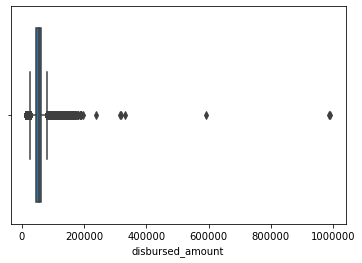

asset_cost


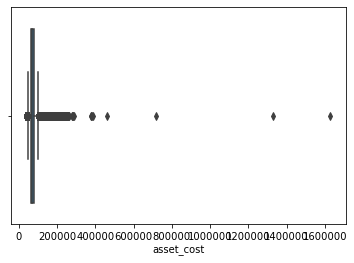

tot_current_balance


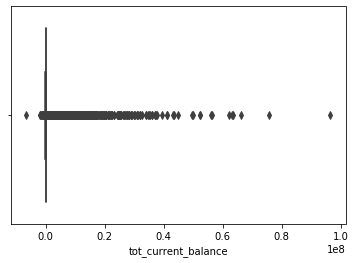

tot_sanctioned_amount


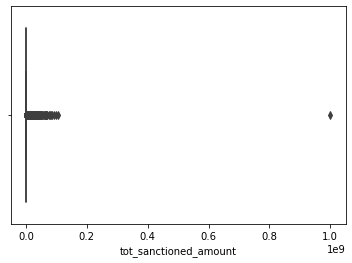

tot_disbursed_amount


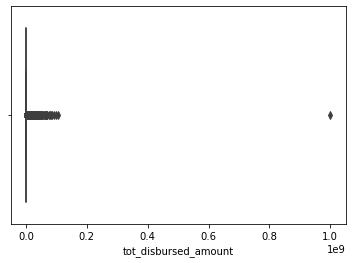

tot_installment


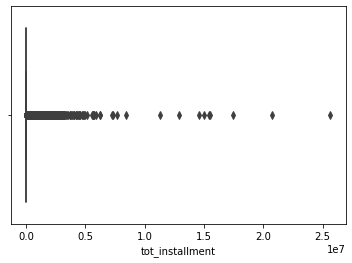

In [8]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [9]:
col,val=[],[]
for i in cols:
    q1=df[i].quantile(0.25)
    q3=df[i].quantile(0.75)
    iqr=q3-q1
    print(i, q3+iqr)
    df.loc[df[i] > q3+iqr,i] = np.nan

disbursed_amount 73681.0
asset_cost 92686.5
tot_current_balance 74672.0
tot_sanctioned_amount 131299.5
tot_disbursed_amount 128568.0
tot_installment 4166.0


In [10]:
df.loc[df['tot_current_balance'] < q1-iqr,'tot_current_balance'] = np.nan

disbursed_amount


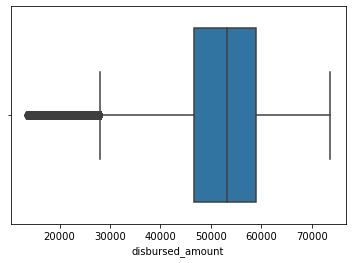

asset_cost


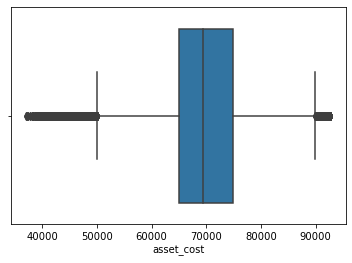

tot_current_balance


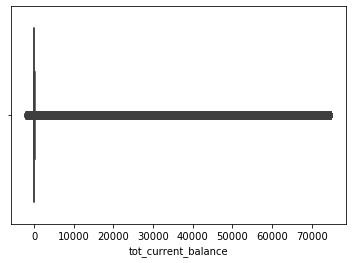

tot_sanctioned_amount


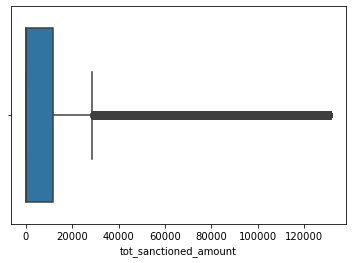

tot_disbursed_amount


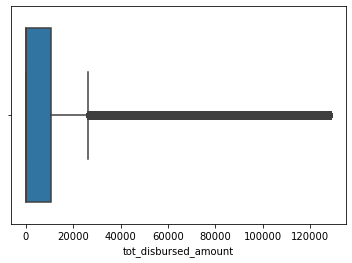

tot_installment


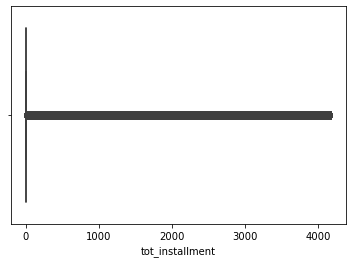

In [11]:
for i in cols:
    print(i)
    sns.boxplot(df[i])
    plt.show()

In [12]:
df[df['tot_current_balance']<0]

,disbursed_amount,asset_cost,ltv,manufacturer_id,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,...,employment_label,Age,disbursal_months_passed,no_of_accts,tot_inactive_accts,tot_overdue_accts,tot_current_balance,tot_sanctioned_amount,tot_disbursed_amount,tot_installment
8,53713.0,61973.0,89.56,45,1,0,0,0,0,718,...,0,28,15,1,0,0,-41.0,NaN,NaN,0.0
434,48599.0,66245.0,75.48,45,1,0,0,0,0,630,...,1,23,14,1,0,0,-367.0,0.0,0.0,0.0
810,44909.0,75001.0,62.67,45,1,0,0,0,0,532,...,1,37,15,1,0,0,-60.0,15000.0,15000.0,0.0
906,50303.0,71762.0,71.07,45,1,0,0,0,0,671,...,0,33,14,1,0,0,-737.0,1015.0,1015.0,0.0
1438,49349.0,74299.0,67.30,86,1,0,0,0,0,517,...,0,35,15,7,6,1,-706.0,706.0,706.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
229024,34939.0,73903.0,48.71,86,1,0,0,0,0,790,...,0,33,14,13,12,0,-93.0,63000.0,56245.0,NaN
229245,51203.0,66660.0,78.76,45,0,0,1,0,0,557,...,0,41,14,2,1,0,-32.0,50000.0,50000.0,0.0
229982,44849.0,74961.0,61.37,45,1,0,0,0,0,561,...,0,45,14,1,0,0,-104.0,45180.0,45180.0,NaN
230210,67669.0,76424.0,89.63,45,1,0,0,0,0,725,...,-1,20,14,2,1,0,-1.0,50000.0,0.0,0.0


In [17]:
x=df[cols].values

In [18]:
x

array([[50578., 58400.,     0.,     0.,     0.,     0.],
       [47145., 65550., 27600., 50200., 50200.,  1991.],
       [53278., 61360.,     0.,     0.,     0.,     0.],
       ...,
       [33484., 71212.,     0.,     0.,     0.,     0.],
       [34259., 73286.,     0.,     0.,     0.,     0.],
       [   nan,    nan,     0.,     0.,     0.,     0.]])

In [157]:
df.isna().sum()

disbursed_amount                       12412
asset_cost                             31932
ltv                                        0
manufacturer_id                            0
Aadhar_flag                                0
PAN_flag                                   0
VoterID_flag                               0
Driving_flag                               0
Passport_flag                              0
PERFORM_CNS.SCORE                          0
SEC.ACTIVE.ACCTS                           0
NEW.ACCTS.IN.LAST.SIX.MONTHS               0
DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS        0
AVERAGE.ACCT.AGE                           0
CREDIT.HISTORY.LENGTH                      0
NO.OF_INQUIRIES                            0
loan_default                               0
credit_risk_label                          0
sub_risk_label                             0
employment_label                           0
Age                                        0
disbursal_months_passed                    0
no_of_acct

In [19]:
imputer = KNNImputer(missing_values=np.nan, n_neighbors=4)

In [20]:
dff=imputer.fit_transform(x)

MemoryError: Unable to allocate array with shape (88679, 233154) and data type float64

In [ ]:
k=0
cols=[]
for i in num_cols:
    df1=df.groupby('target').get_group(0)
    df2=df.groupby('target').get_group(1)
    t,p=ttest_ind(df1[i],df2[i])
    print('Chi Square P Value for column ',i,': ',p)